In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import flatten_dict
import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
import pylab as pyl
%matplotlib inline
from dabs.src.systems import viewmaker, viewmaker_original

config = OmegaConf.load('/disk2/ofirb/dabs/conf/pretrain_original.yaml')
config.debug = True
config.dataset = OmegaConf.load('/disk2/ofirb/dabs/conf/dataset/cifar10_small.yaml')
config.model = OmegaConf.load('/disk2/ofirb/dabs/conf/model/resnet_small.yaml')

config.dataset.batch_size = 10

pl.seed_everything(config.trainer.seed)

if config.algorithm == 'viewmaker':
    system = viewmaker.ViewmakerSystem(config)
elif config.algorithm == 'original_viewmaker':
    system = viewmaker_original.OriginalViewmakerSystem(config)
elif config.algorithm == 'tama_viewmaker':
    system = viewmaker_original.ViewmakerTAMA38System(config)
system.setup('')
if config.trainer.resume_from_checkpoint:
    system.load_state_dict(torch.load(config.trainer.resume_from_checkpoint)['state_dict'],strict=False)

/disk2/ofirb/enviroments/viewmaker/lib/python3.7/site-packages/librosa/core/constantq.py:1059: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.complex,
Global seed set to 0


Files already downloaded and verified
Files already downloaded and verified
50000 train examples, 10000 val examples


In [12]:
import umap
from dabs.src.datasets.utils import fraction_db

frac_indx = fraction_db(system.val_dataset, 0.5)[0]


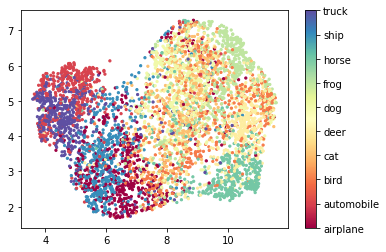

In [13]:
umap_projection  = umap.UMAP(n_neighbors=500,metric='cosine').fit_transform(system.memory_bank._bank[frac_indx].cpu().numpy())
plt.clf()
plt.scatter(umap_projection[:, 0], umap_projection[:, 1], s= 5, c=system.memory_bank_labels._bank[frac_indx].cpu().numpy(), cmap='Spectral')
cbar = plt.colorbar(ticks=range(10))
cbar.ax.set_yticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.show()

### 10.5.2022 todos
- [ ] use different explainability source
- [ ] add constraints to delta optimization ( descriminator / clip?? )
- [x] continue low temp run
- [x] run high temp vm after trained with low temp

In [3]:
system.eval()
loader = system.train_dataloader()
for batch in loader:
    break
    
emb_dict = system.ssl_forward(batch)
encoder_loss, encoder_acc, view_maker_loss, positive_sim, negative_sim = system.objective(emb_dict)
print(encoder_loss,positive_sim,negative_sim)

tensor(-2.1161, grad_fn=<NegBackward>) tensor(0.9773, grad_fn=<MeanBackward0>) tensor(0.2523, grad_fn=<MeanBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


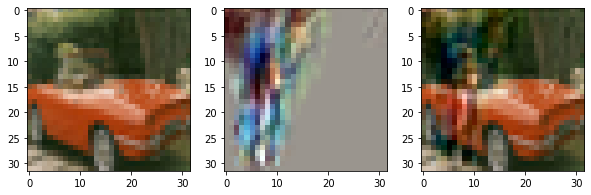

In [4]:
image_ = batch[1]

_, view_ = system.view(image_,True)
view_ = view_.detach().cpu()[0]
image_ = image_[0]

# image_.shape
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(image_.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(image_,view_).permute(1,2,0))
axs[2].imshow(view_.permute(1,2,0))
fig.show()

In [15]:
class SimilarityLoss(torch.nn.Module):
    def __init__(self, target,):
        super(SimilarityLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = self.target @ input
        return self.loss

def forward(delta,original):
    avg_dist = delta.abs().mean()
    just_delta = delta * 0.05 / (avg_dist + 1e-4)
    _input = (original + just_delta).clamp(0,1)
    _input_embeds = system.model([system.normalize(_input)])[0]
    _input_embeds = _input_embeds / _input_embeds.norm()
    return _input_embeds


def optimize_delta(delta,original,epochs=1000, lr = 2e-4,toloss=-1):
    similarity = SimilarityLoss(system.model([system.normalize(original)])[0])
    
    delta.requires_grad_(True)
    system.model.requires_grad_(False)
    optimizer = torch.optim.Adam([delta],lr=lr)

    for epoch in range(epochs):
        # correct the values of updated input image
        optimizer.zero_grad()
        _input_embeds = forward(delta,original)
        loss = similarity(_input_embeds)
        if loss.item() < toloss:
            break
        loss.backward()

        optimizer.step()

    return delta


# noise = 2*torch.rand_like(img) -1
# avg_dist = noise.abs().mean()
# random_delta = noise * 0.05 / (avg_dist + 1e-4)

# refs = optimize_delta(random_delta)

In [16]:
noise = 2*torch.rand_like(image_) -1
avg_dist = noise.abs().mean()
random_delta = noise * 0.05 / (avg_dist + 1e-4)

d = (view_ - image_).clone()
delta_optimized = optimize_delta(d,image_,epochs=1000,lr = 1e-3,toloss=-0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


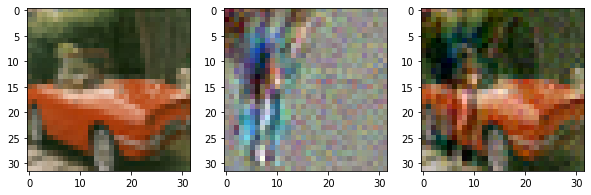

In [17]:
# image_.shape
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(image_.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(image_,image_+delta_optimized.cpu().detach()).permute(1,2,0))
axs[2].imshow((image_+delta_optimized.cpu().detach()).permute(1,2,0))
fig.show()

In [ ]:
from viewmaker.src.gans.tiny_pix2pix import TinyP2PDiscriminator

disc = TinyP2PDiscriminator(in_channels=3,wgan=False,blocks_num=4)
disc_optim = torch.optim.Adam(disc.parameters(),lr=0.0001)


image_.requires_grad = True # ?
# real_s = disc(system.normalize(img))
# fake_s = torch.cat([disc(views1), disc(views2)], dim=0)
real_s = torch.cat([disc(view_), disc(views2)], dim=0)
fake_s = 0
loss_n_acc = disc.calc_loss_and_acc(real_s, fake_s,r1_penalty=0.000001)